In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO

import torch
from torchvision.ops import nms

import onnxruntime as ort
import onnx
from onnx import compose
from onnx import helper, TensorProto

from landmark_detection.yolov8_cvnet_sg import PostProcess 

In [2]:
# Funciones
def show_image(img_rgb):    
    # Mostrar la imagen original
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

def show_yolo_results(results):
    # Extraer detecciones del primer batch
    res0 = results[0]
    boxes = res0.boxes.xyxy.cpu().numpy()   # (N,4): x1,y1,x2,y2 en píxeles [0–639]
    scores = res0.boxes.conf.cpu().numpy()  # (N,)
    cls = res0.boxes.cls.cpu().numpy().astype(int)  # (N,)

    # Visualizar bounding boxes
    show_yolo_onnx_results(boxes, cls, scores)

def show_yolo_onnx_results(boxes, cls, scores):
    print(f"Encontradas {len(boxes)} cajas:")
    for i in range(len(boxes)):
        x1,y1,x2,y2 = boxes[i]
        class_name = class_names[cls[i]]
        print(f"  Clase {cls[i]} {class_name} @ {scores[i]:.2f} → [{x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f}]")
        
    plt.figure(figsize=(6,6))
    plt.imshow(img_resized)
    ax = plt.gca()
    
    for (x1,y1,x2,y2), cls, sc in zip(boxes, cls, scores):
        rect = plt.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False, linewidth=2, edgecolor='red'
        )
        ax.add_patch(rect)
        class_name = class_names[cls]
        ax.text(
            x1, y1 - 4,
            f"{class_name}:{sc:.2f}",
            color='white', fontsize=9,
            bbox=dict(facecolor='red', alpha=0.5)
        )
    
    plt.axis('off')
    plt.show()

def show_crops(crops, cols=4, figsize=(12, 12)):
    """
    Muestra todos los crops en una cuadrícula.
    
    Args:
        crops (torch.Tensor o np.ndarray): Tensor de forma (M, 3, 224, 224) o arreglo de numpy equivalente.
        cols (int): Número de columnas en la cuadrícula.
        figsize (tuple): Tamaño de la figura matplotlib (ancho, alto).
    
    Ejemplo de uso en el notebook:
        # crops: tensor (M, 3, 224, 224)
        mostrar_crops_en_cuadricula(crops, cols=4, figsize=(12,12))
    """
    # Convertir a numpy de forma (M, 224, 224, 3)
    if isinstance(crops, torch.Tensor):
        arr = crops.detach().cpu().permute(0, 2, 3, 1).numpy()
    else:
        arr = np.array(crops)
        # Si viene con shape (M, 3, 224, 224), pasarlo a (M, 224, 224, 3)
        if arr.ndim == 4 and arr.shape[1] == 3:
            arr = arr.transpose(0, 2, 3, 1)

    M = arr.shape[0]
    if M == 0:
        print("No hay crops para mostrar.")
        return

    # Calcular número de filas según columnas deseadas
    rows = (M + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i in range(rows * cols):
        ax = axes[i]
        if i < M:
            # Mostrar la imagen i-ésima
            ax.imshow(arr[i])
            ax.axis("off")
        else:
            # Espacio vacío si M no llena la cuadricula completa
            ax.axis("off")

    plt.tight_layout()
    plt.show()

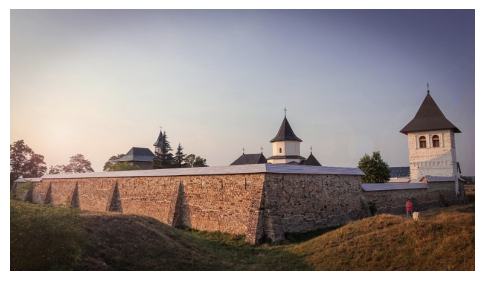

In [3]:
# Carga de imagen
IMAGE_PATH = 'test.jpg'

img_bgr = cv2.imread(IMAGE_PATH)
if img_bgr is None:
    raise FileNotFoundError(f"No se encontró la imagen en {IMAGE_PATH}")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

show_image(img_rgb)

In [4]:
# Preprocesado

# Redimensionar a 640×640
img_resized = cv2.resize(img_rgb, (640, 640))

# Convertir a tensor CHW y normalizar a [0,1] float32
img_tensor = torch.from_numpy(img_resized).permute(2,0,1).float() / 255.0
img_tensor = img_tensor.unsqueeze(0)  # shape (1,3,640,640)

print("Tensor shape:", img_tensor.shape, "dtype:", img_tensor.dtype)

Tensor shape: torch.Size([1, 3, 640, 640]) dtype: torch.float32


Número de clases del modelo: 601

0: 640x640 1 Building, 2 Houses, 2 Towers, 9 Trees, 135.1ms
Speed: 0.0ms preprocess, 135.1ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)
Encontradas 14 cajas:
  Clase 553 Tree @ 0.51 → [476.7,343.5,525.4,426.8]
  Clase 553 Tree @ 0.41 → [0.0,314.2,53.2,463.3]
  Clase 553 Tree @ 0.39 → [54.7,351.2,118.9,403.1]
  Clase 257 House @ 0.22 → [2.0,238.7,635.2,585.8]
  Clase 70 Building @ 0.20 → [1.9,238.1,637.5,585.1]
  Clase 553 Tree @ 0.19 → [193.6,287.3,226.8,392.1]
  Clase 553 Tree @ 0.16 → [194.1,322.4,274.2,390.7]
  Clase 546 Tower @ 0.16 → [354.2,241.3,406.4,373.2]
  Clase 257 House @ 0.15 → [127.6,334.5,205.9,395.8]
  Clase 553 Tree @ 0.15 → [192.3,295.8,274.1,391.4]
  Clase 553 Tree @ 0.14 → [0.0,314.2,51.0,418.2]
  Clase 546 Tower @ 0.12 → [533.4,177.8,627.1,442.1]
  Clase 553 Tree @ 0.11 → [130.2,290.2,274.4,393.5]
  Clase 553 Tree @ 0.11 → [215.8,325.9,275.0,389.7]


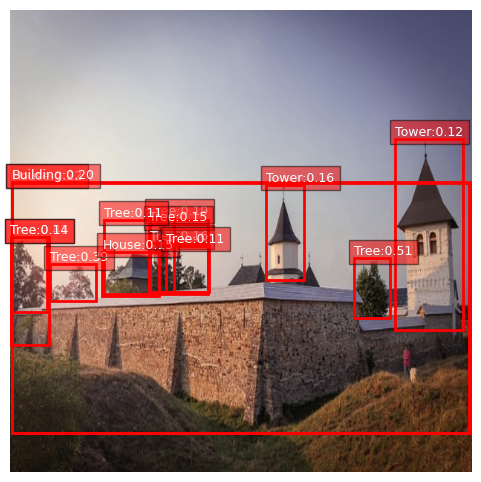

In [5]:
# Inferencia con el modelo .pt
model = YOLO("yolov8n-oiv7.pt")
class_names = model.names
print("Número de clases del modelo:", len(model.names))

results = model(img_tensor, imgsz=640, conf=0.1)      # devuelve lista de Results
show_yolo_results(results)

In [6]:
model.export(
    format="onnx",
    imgsz=640,
    opset=16,
    name="yolov8n-oiv7", 
    simplify=True
)

Ultralytics 8.3.146  Python-3.11.11 torch-2.7.0+cpu CPU (Intel Core(TM) i5-9300HF 2.40GHz)

PyTorch: starting from 'yolov8n-oiv7.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 605, 8400) (6.9 MB)

ONNX: starting export with onnx 1.17.0 opset 16...
ONNX: slimming with onnxslim 0.1.54...
ONNX: export success  1.3s, saved as 'yolov8n-oiv7.onnx' (13.5 MB)

Export complete (1.6s)
Results saved to C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval
Predict:         yolo predict task=detect model=yolov8n-oiv7.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8n-oiv7.onnx imgsz=640 data=/usr/src/ultralytics/ultralytics/cfg/datasets/open-images-v7.yaml  
Visualize:       https://netron.app


'yolov8n-oiv7.onnx'

In [7]:
# Inferencia ONNX + post‐procesado con NMS

# Cargar sesión ONNX
sess = ort.InferenceSession("yolov8n-oiv7.onnx", providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name

# Ejecutar inferencia sobre el tensor preparado (batch,3,640,640)
onnx_out = sess.run(None, {input_name: img_tensor.numpy()})[0]  

# Post‐procesar
pred   = torch.from_numpy(onnx_out).squeeze(0)    # shape (5+C, N)
pred   = pred.transpose(0, 1)                     # shape (N, 5+C)
boxes = pred[:, :4]                               # cx,cy,w,h

# Convertir a xyxy
cx, cy, w, h = boxes.unbind(1)
x1 = cx - w/2; y1 = cy - h/2; x2 = cx + w/2; y2 = cy + h/2
boxes = torch.stack([x1,y1,x2,y2], dim=1)

# Calcular scores
obj_logits = pred[:, 4]
cls_logits = pred[:, 5:]
obj_conf = obj_logits
cls_conf, cls_ids = cls_logits.max(1)
cls_ids = cls_ids + 1
scores = cls_conf

# Non‐Max Suppression
keep_nms = nms(boxes, scores, iou_threshold=0.45)
keep = keep_nms[scores[keep_nms] > 0.1]  # filtrar por score mínimo

yolo_onnx_boxes = boxes[keep].cpu().numpy()
yolo_onnx_scores = scores[keep].cpu().numpy()
yolo_onnx_cls   = cls_ids[keep].cpu().numpy()

Encontradas 10 cajas:
  Clase 553 Tree @ 0.51 → [476.7,343.5,525.4,426.8]
  Clase 553 Tree @ 0.41 → [-0.0,314.2,53.2,463.3]
  Clase 553 Tree @ 0.39 → [54.7,351.2,118.9,403.1]
  Clase 257 House @ 0.22 → [2.0,238.7,635.2,585.8]
  Clase 553 Tree @ 0.19 → [193.6,287.3,226.8,392.1]
  Clase 553 Tree @ 0.16 → [194.1,322.4,274.2,390.7]
  Clase 546 Tower @ 0.16 → [354.2,241.3,406.4,373.2]
  Clase 257 House @ 0.15 → [127.6,334.5,205.9,395.8]
  Clase 546 Tower @ 0.12 → [533.4,177.8,627.1,442.1]
  Clase 553 Tree @ 0.11 → [130.2,290.2,274.4,393.5]


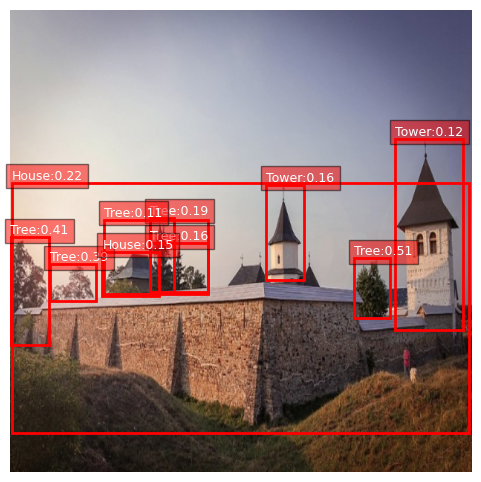

In [8]:
# Visualizar resultados ONNX
show_yolo_onnx_results(yolo_onnx_boxes, yolo_onnx_cls, yolo_onnx_scores)

In [9]:
# Cargar sesión ONNX
sess = ort.InferenceSession("yolov8n-oiv7.onnx", providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name

# Ejecutar inferencia sobre el tensor preparado (batch,3,640,640)
onnx_out = sess.run(None, {input_name: img_tensor.numpy()})
raw_pred = torch.from_numpy(onnx_out[0])

In [10]:
oiv7_classes = [41,68,70,74,87,95,113,144,150,158,164,165,193,205,212,224,257,298,310,335,351,354,390,393,401,403,439,442,457,466,489,510,512,514,524,530,531,543,546,554,565,573,580,587,588,591]
pipeline = PostProcess(oiv7_classes)
pipeline.eval()
with torch.no_grad():
    pipeline_out = pipeline(raw_pred, img_tensor)

Encontradas 4 cajas:
  Clase 257 House @ 0.22 → [2.0,238.7,635.2,585.8]
  Clase 546 Tower @ 0.16 → [354.2,241.3,406.4,373.2]
  Clase 257 House @ 0.15 → [127.6,334.5,205.9,395.8]
  Clase 546 Tower @ 0.12 → [533.4,177.8,627.1,442.1]


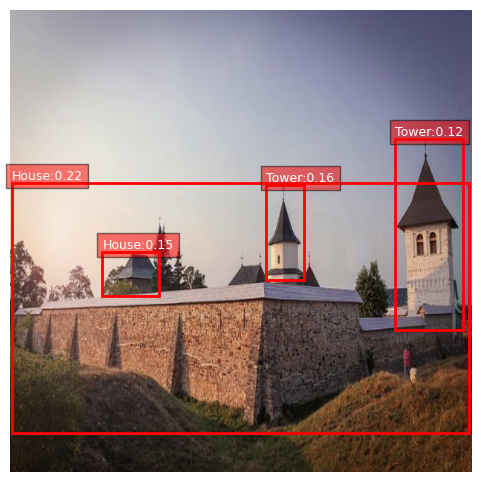

In [11]:
# Visualizar resultados Pipeline
show_yolo_onnx_results(pipeline_out[0].numpy(), pipeline_out[2].numpy(), pipeline_out[1].numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0397916..2.2159703].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.97923..2.197818].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7782574..2.2423503].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7111503..2.0599787].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9887621..1.9996859].


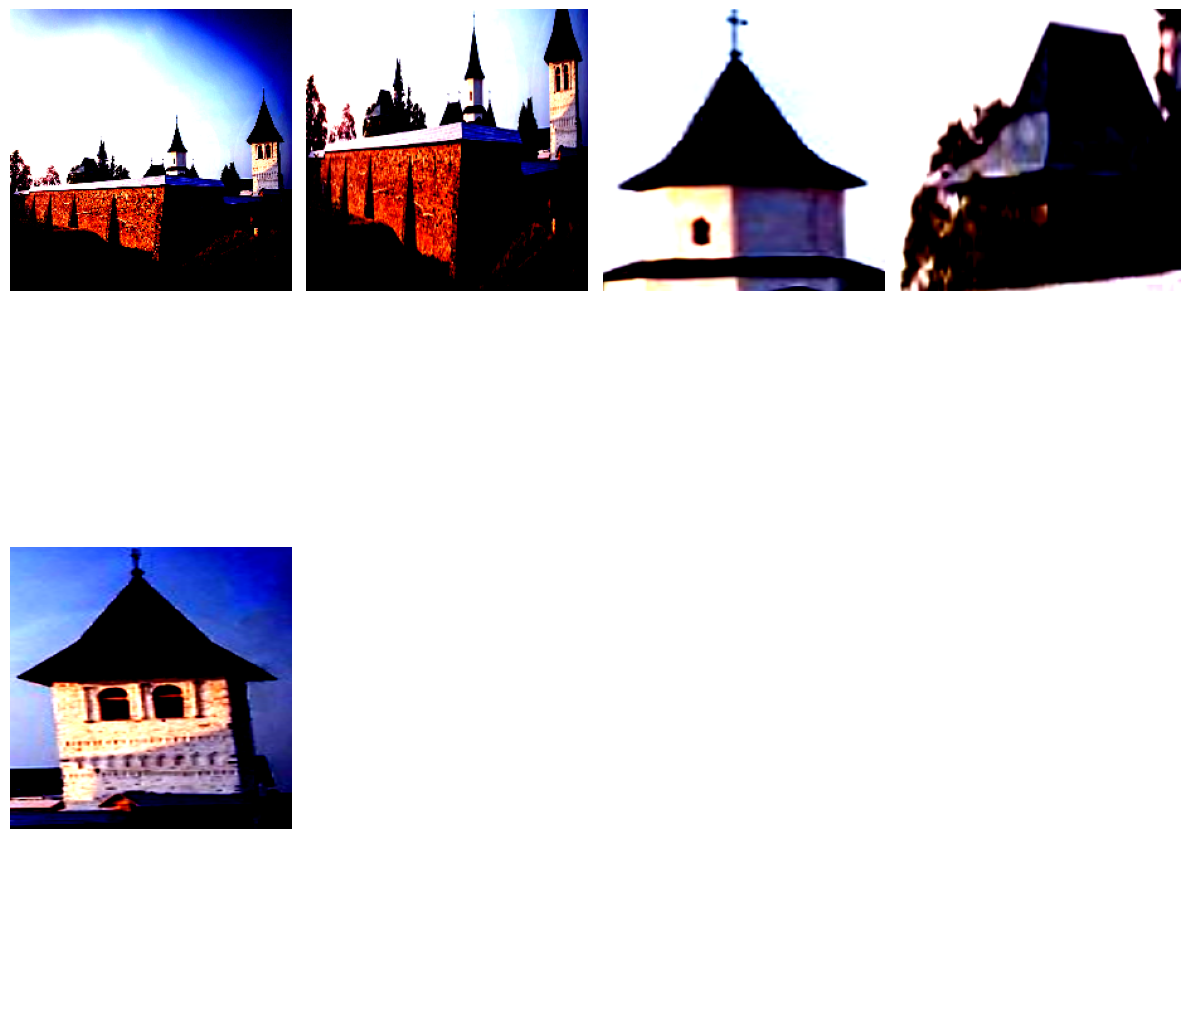

In [12]:
show_crops(pipeline_out[3].numpy())

In [13]:
# Exportar a ONNX
torch.onnx.export(
    pipeline,
    (raw_pred, img_tensor),
    "postproc.onnx",
    opset_version=16,                   # OPS versión >= 11 para NMS
    input_names=["output0", "p_images"],           # nombre del input
    output_names=["boxes", "scores", "classes", "crops"],
    dynamic_axes={
        "boxes":    {0: "num_boxes"},   
        "scores":   {0: "num_boxes"},
        "classes":  {0: "num_boxes"},
        "crops":    {0: "num_boxes"}  
   },
    do_constant_folding=True
)

In [14]:
# Cargar el modelo YOLO original
yolo_path = "yolov8n-oiv7.onnx"
model = onnx.load(yolo_path)
graph = model.graph

# Identificar el nombre del input de YOLO
input_name = graph.input[0].name
print(f"YOLO input detectado: {input_name}")

# Crear un nodo Identity que copie ese input a un nuevo tensor "images_out"
identity_node = helper.make_node(
    "Identity",
    inputs=[input_name],      # la entrada original de YOLO ("images")
    outputs=["images_out"],   # nuevo nombre de tensor que contendrá la misma imagen
    name="Identity_ExposeImages"
)

# Añadir ese nodo al final de graph.node
graph.node.append(identity_node)

# Declarar “images_out” como nuevo output del grafo, con la misma shape/dtipo que "images"
# Podemos extraer la shape/dtipo del input para no recortarla a mano:
input_type = graph.input[0].type.tensor_type.elem_type  # debería ser FLOAT (1)
input_shape = []
for dim in graph.input[0].type.tensor_type.shape.dim:
    # Si el dim_value > 0, lo tomamos; si es simbólico, dejamos dim_param
    if dim.dim_value > 0:
        input_shape.append(dim.dim_value)
    else:
        input_shape.append(dim.dim_param)

new_output = helper.make_tensor_value_info(
    name="images_out",
    elem_type=input_type,
    shape=input_shape
)
graph.output.append(new_output)

# 1.6) Guardar el ONNX modificado en disco
output_yolo = "yolov8n-oiv7.onnx"
onnx.save(model, output_yolo)

YOLO input detectado: images


In [15]:
# 1) Cargar ambos modelos
yolo_model = onnx.load("yolov8n-oiv7.onnx")
pp_model   = onnx.load("postproc.onnx")

merged_model = compose.merge_models(
    yolo_model,
    pp_model,
    io_map=[("images_out", "p_images"),("output0", "output0")]
)

onnx.checker.check_model(merged_model)  # valida topológica y esquemas
onnx.save(merged_model, "full_pipeline.onnx")

In [16]:
# Cargar sesión ONNX
sess = ort.InferenceSession("full_pipeline.onnx", providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name

# Ejecutar inferencia sobre el tensor preparado (batch,3,640,640)
full_out = sess.run(None, {input_name: img_tensor.numpy()})

Encontradas 4 cajas:
  Clase 257 House @ 0.22 → [2.0,238.7,635.2,585.8]
  Clase 546 Tower @ 0.16 → [354.2,241.3,406.4,373.2]
  Clase 257 House @ 0.15 → [127.6,334.5,205.9,395.8]
  Clase 546 Tower @ 0.12 → [533.4,177.8,627.1,442.1]


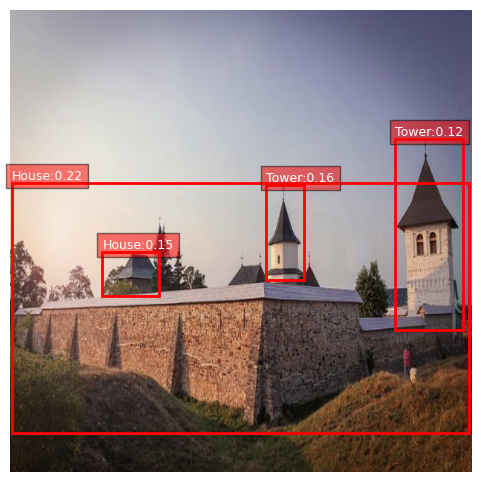

In [17]:
# Visualizar resultados Pipeline
show_yolo_onnx_results(full_out[0], full_out[2], full_out[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0397916..2.215969].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.97923..2.197818].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7782574..2.2423503].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7111503..2.0599787].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9887621..1.9996859].


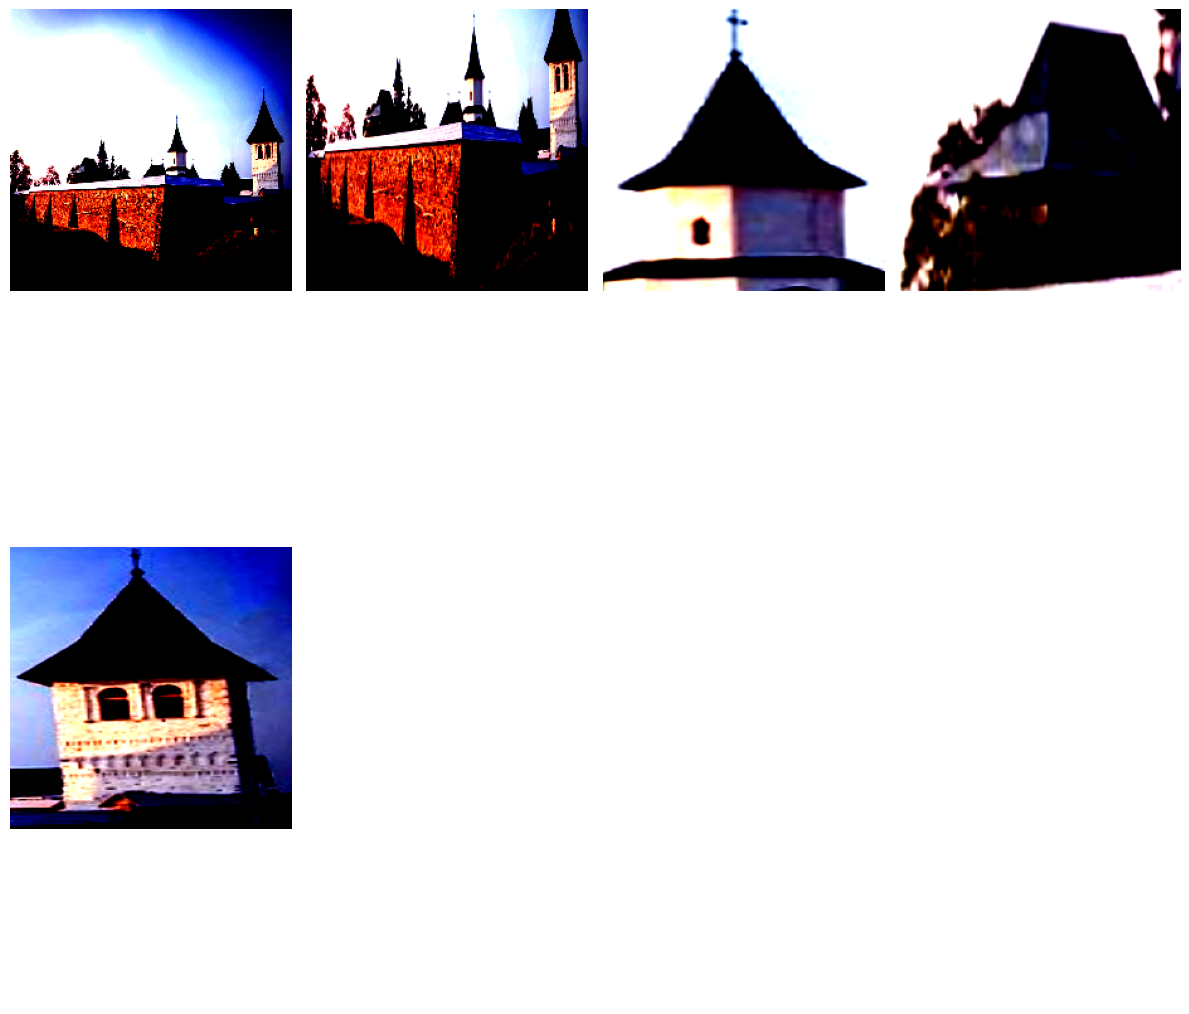

In [18]:
show_crops(full_out[3])

In [19]:
from landmark_detection.backbone import CVNet
import torch 

# Instanciamos CVNet con exactamente los mismos hiperparámetros que el checkpoint
cvnet = CVNet(RESNET_DEPTH=50, REDUCTION_DIM=2048)
cvnet.eval()

with torch.no_grad():
    crops_tensor = torch.from_numpy(full_out[3])
    out = cvnet(crops_tensor)  # → debería ser tamaño (2, 2048) y normalizado (norma=1)

In [20]:
out.shape

torch.Size([2048, 7, 7])